In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot 
from scipy.stats import shapiro,ttest_ind
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('All_data.csv')

In [3]:
grades = pd.read_csv('All_grades.csv')

# Data Cleaning

In [4]:
users = grades.user_id.tolist()

In [5]:
user_id = []
for i in data['Description']:
    try:
        discovered_id = i.split("'")[1].replace('.',"")
        _ = int(discovered_id)
        
        user_id.append(discovered_id)
        
    except:
        user_id.append('error')
 

In [6]:
data['user_id'] = user_id
data_users = data.user_id.unique().tolist()

In [7]:
data_users_int = []
for i in data_users:
    try: 
        data_users_int.append(int(i))
    except: 
        continue

In [8]:
not_students = list(set(data_users_int) - set(users))

In [9]:
not_students.append('error')
not_students = [str(i) for i in not_students]
not_students[:10]

['0', '5120', '2', '5123', '5125', '5130', '7179', '5133', '5135', '2064']

In [10]:
data=data[~data.user_id.isin(not_students)]

In [11]:
data = data.reset_index(drop = True)

# Dictionary

In [12]:
data['Time'] = pd.to_datetime(data['Time'], dayfirst=True)

In [13]:
def extract_date(datetime):
    return datetime.day, datetime.week, datetime.month,datetime.year

data['day'], data['week'], data['month'], data['year'] = zip(*data['Time'].map(extract_date))

data['week'] = data['week'] - (data['week'].min() -1)

In [14]:
interval_def_template = {
       'start_date': '',
       'end_date': '',
       'student_ids' : {}
}

In [15]:
def filter_intervals_data(data, time='week'):

    user_activity_dict = {}

    interval_range = sorted(data[time].unique())
    unique_event_dict = {item : 0 for item in data['Event name'].unique()}

    for interval in tqdm(interval_range):
        interval_def_template = {
           'start_date': '',
           'end_date': '',
           'student_ids' : {}
        }

        dict_template = {}

        filtered_data = data[data[time]==interval]
        int_start, int_end = str(filtered_data.Time.min().date()), str(filtered_data.Time.max().date())

        interval_def_template['start_date'], interval_def_template['end_date'] = int_start, int_end

        for user_id in filtered_data.user_id.unique():
            
            user_filtered_events = filtered_data[filtered_data.user_id==user_id]['Event name'].value_counts()
            dict_template[user_id] = dict(unique_event_dict)

            for event, count in dict(user_filtered_events).items():
                dict_template[user_id][event] = count
            
            dict_template[user_id]['type'] = filtered_data[filtered_data.user_id==user_id]['type'].unique()[0]
            dict_template[user_id]['level'] = filtered_data[filtered_data.user_id==user_id]['level'].unique()[0]

        interval_def_template['student_ids'] = dict_template

        user_activity_dict[f"{time}_{interval}"] = interval_def_template
        
    return user_activity_dict
    


# Dict to Dataframe and Merging with Grades

In [16]:
user_filtered_events = filter_intervals_data(data, time='year')

100%|██████████| 1/1 [00:28<00:00, 28.64s/it]


In [17]:
total_user_activity = []
time_interval_list = []

for time_interval, user_events in user_filtered_events.items():
    total_user_activity.append(
        pd.DataFrame(user_filtered_events[f'{time_interval}']['student_ids'].values(), index=user_filtered_events[f'{time_interval}']['student_ids'].keys()))
    
for time_interval, user_events in user_filtered_events.items():
    time_list = [time_interval for i in range(len(user_filtered_events[time_interval]['student_ids'].keys()))]
    time_interval_list+=time_list

In [18]:
k = pd.concat(total_user_activity).reset_index()

In [19]:
time_interval_df = pd.DataFrame(time_interval_list, columns = ['time_interval'])

In [20]:
final = pd.concat([time_interval_df, k], axis=1)

In [21]:
final.rename(columns={'index': 'user_id'},inplace =True)

In [22]:
final.user_id = final.user_id.astype('int')

In [23]:
final = final.merge(grades, on  = 'user_id',how = 'left')

In [24]:
final.dropna(inplace = True)

In [25]:
final.head()

,time_interval,user_id,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,User profile viewed,Course activity completion updated,Course user report viewed,...,Subscription created,Subscription deleted,Group member added,Choice answer deleted,Grade item updated,Recent activity viewed,An online text has been uploaded.,type,level,Grades
0,year_2020,2308,312,869,110,805,89,14,58,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.3
1,year_2020,1931,190,608,32,332,7,3,69,208,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
2,year_2020,2084,257,416,75,353,2,1,69,36,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.7
3,year_2020,2378,331,725,113,564,39,2,57,1,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
4,year_2020,1943,544,1114,179,1890,152,33,85,9,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0


# Data Visualization

In [26]:
undergrad = final[final.level == 'undergrad']
grad = final[final.level == 'grad'] 
Quantitative = final[final.type == 'Quantitative']
Qualitative = final[final.type == 'Qualitative']

In [27]:
from matplotlib.pyplot import *

In [28]:
print (plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [29]:
plt.style.use('ggplot')

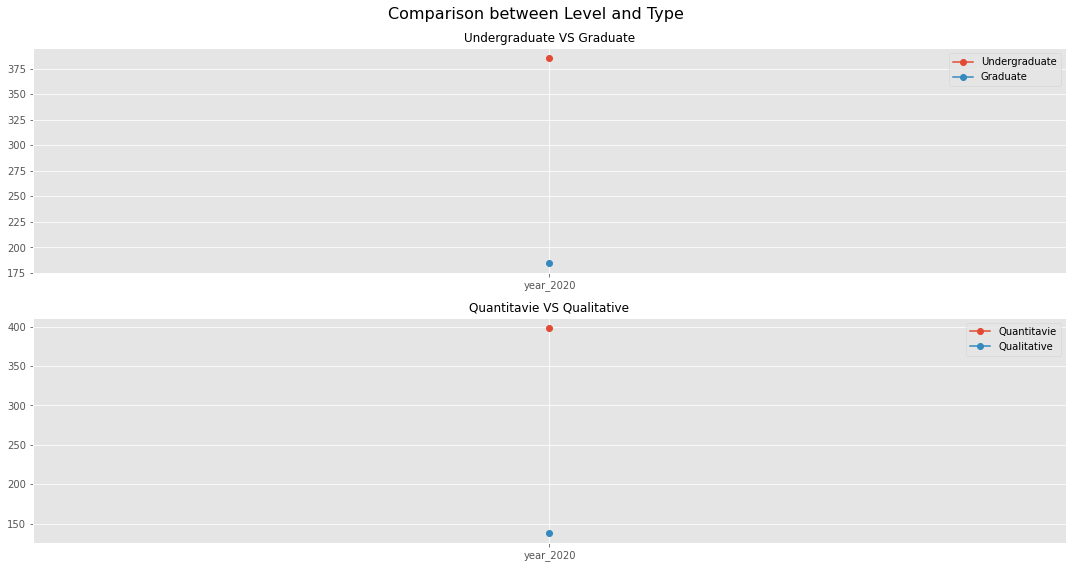

In [30]:

plt.figure(figsize=(15, 8))


plt.subplot(2,1,1)
plt.suptitle('Comparison between Level and Type',fontsize=16)
plt.plot(undergrad.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.plot(grad.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.legend(['Undergraduate','Graduate'])
plt.title('Undergraduate VS Graduate',fontsize=12)
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(Quantitative.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.plot(Qualitative.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.legend(['Quantitavie','Qualitative'])
plt.title("Quantitavie VS Qualitative",fontsize=12)
plt.tight_layout()
plt.show()

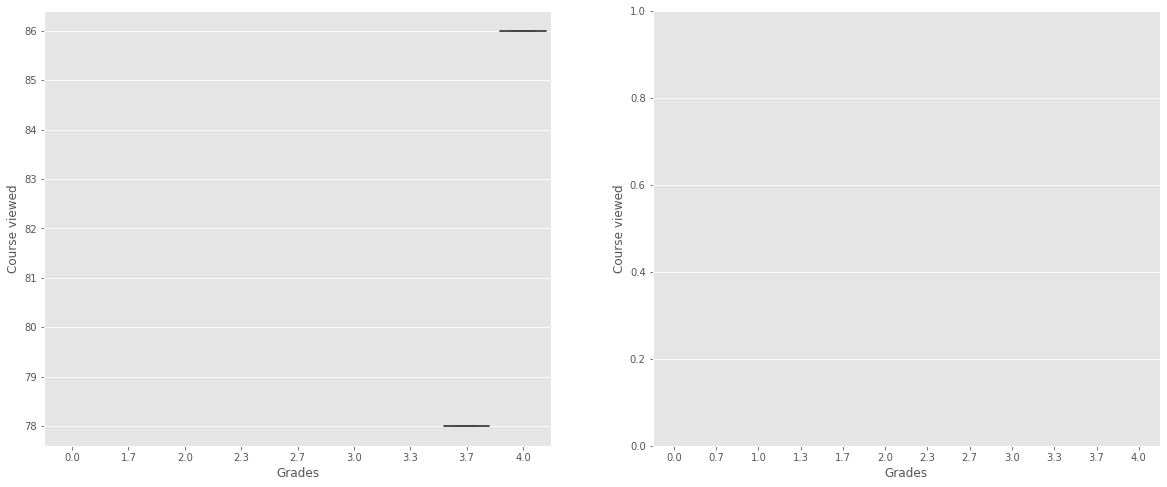

In [31]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(grad.Grades, grad.groupby('user_id')['Course viewed'].sum())
plt.subplot(1,2,2)
sns.boxplot(undergrad.Grades, undergrad.groupby('user_id')['Course viewed'].sum())
plt.show()

# Modeling

In [32]:
test = final.copy()

In [33]:
for i in test.columns:
    if sum(test[i].values == 0) > 0.3*len(test):
        test.drop(i,axis=1,inplace = True)

In [34]:
test = test.drop(['time_interval','user_id'], 1)

In [35]:
test.Grades = np.where(test.Grades < 3, 'Low Performance', 'High Performance')

In [36]:
X = pd.get_dummies(test.drop('Grades', axis = 1))
Y = test.Grades

### PCA

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [40]:
X_scaled = X

In [44]:
pca = PCA(n_components=5)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [45]:
print(pca.explained_variance_ratio_)

[0.84120077 0.05615661 0.04820768 0.02783423 0.0132229 ]


In [46]:
print(sum(pca.explained_variance_ratio_))

0.986622174915376


In [47]:
print(pca.singular_values_)

[8634.49124343 2230.93725075 2067.0217346  1570.63942451 1082.55556875]


In [48]:
X_pca = pca.fit_transform(X_scaled)


In [49]:
X_pca[:5]

array([[ 677.82303456,   19.25217166, -120.77463794,  108.47535378,
           8.69710773],
       [ 168.46655501, -210.37776787,  -61.48877774,   30.43553367,
         -36.40184944],
       [  76.86004431, -156.59634975, -151.28353497,  -92.24318008,
          55.55449621],
       [ 441.63542631, -155.56463162, -161.32071032,   28.23857146,
          29.58613437],
       [1646.32889722,  535.02035816, -316.6040328 , -106.24220674,
         122.58123996]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,Y, test_size = 0.2)

# Logistic Regression

In [51]:
logit = LogisticRegression(max_iter=1e6).fit(X_train,y_train)

In [52]:
print('Accuracy Logistic Regression Train:',logit.score(X_train,y_train))
print('Accuracy Logistic Regression Test:',logit.score(X_test,y_test))

Accuracy Logistic Regression Train: 0.6675824175824175
Accuracy Logistic Regression Test: 0.6847826086956522


In [53]:
Y0_logit = logit.predict_proba(X_train)[:,1]
Y1_logit = logit.predict_proba(X_test)[:,1]
print("ROC AUC Logistic Regression Train", roc_auc_score(y_train,Y0_logit))
print("ROC AUC Logistic Regression Test", roc_auc_score(y_test,Y1_logit))

ROC AUC Logistic Regression Train 0.6278661087866109
ROC AUC Logistic Regression Test 0.5978494623655914


In [54]:
print("Confusion Matrix Logistic Regression Train:")
print(classification_report(y_train,logit.predict(X_train)))

print("Confusion Matrix Logistic Regression Test:")
print(classification_report(y_test,logit.predict(X_test)))

Confusion Matrix Logistic Regression Train:
                  precision    recall  f1-score   support

High Performance       0.67      0.97      0.79       239
 Low Performance       0.61      0.09      0.15       125

        accuracy                           0.67       364
       macro avg       0.64      0.53      0.47       364
    weighted avg       0.65      0.67      0.57       364

Confusion Matrix Logistic Regression Test:
                  precision    recall  f1-score   support

High Performance       0.69      0.98      0.81        62
 Low Performance       0.67      0.07      0.12        30

        accuracy                           0.68        92
       macro avg       0.68      0.53      0.46        92
    weighted avg       0.68      0.68      0.58        92



# Random Forest Classifier

In [55]:
rf = RandomForestClassifier()

In [56]:
param_grid = {
    'n_estimators': np.arange(100,1000,100),
    'max_features': [.3,.5,.7,9],
    'bootstrap': [False, True],
    'max_depth':np.arange(1,15,1)
}

In [57]:
rf_fit = GridSearchCV(estimator=rf, param_grid=param_grid,
      scoring = 'roc_auc',verbose = 1, n_jobs = -1).fit(X_train,y_train)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5040 out of 5040 | elapsed:  5.2min finished


In [64]:
best_params = rf_fit.best_params_

In [65]:
best_params

{'bootstrap': True, 'max_depth': 14, 'max_features': 0.5, 'n_estimators': 100}

In [83]:
rf = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                            max_features = best_params['max_features'],
                            bootstrap = best_params['bootstrap'],
                            max_depth = best_params['max_depth']).fit(X_train,y_train)

In [84]:
print('Accuracy Train Random Forest:', rf.score(X_train,y_train))
print('Accuracy Test Random Forest:', rf.score(X_test,y_test))

Accuracy Train Random Forest: 0.9945054945054945
Accuracy Test Random Forest: 0.6956521739130435


In [85]:
Y0_rf = rf.predict_proba(X_train)[:,1]
Y1_rf = rf.predict_proba(X_test)[:,1]
print("ROC AUC Train Random Forest:", roc_auc_score(y_train,Y0_logit))
print("ROC AUC Test Random Forest:", roc_auc_score(y_test,Y1_logit))

ROC AUC Train Random Forest: 0.6278661087866109
ROC AUC Test Random Forest: 0.5978494623655914


In [86]:
print("Confusion Matrix Random Forest Train:")
print(classification_report(y_train,rf.predict(X_train)))

print("Confusion Matrix Random Forest Test:")
print(classification_report(y_test,rf.predict(X_test)))

Confusion Matrix Random Forest Train:
                  precision    recall  f1-score   support

High Performance       0.99      1.00      1.00       239
 Low Performance       1.00      0.98      0.99       125

        accuracy                           0.99       364
       macro avg       1.00      0.99      0.99       364
    weighted avg       0.99      0.99      0.99       364

Confusion Matrix Random Forest Test:
                  precision    recall  f1-score   support

High Performance       0.76      0.81      0.78        62
 Low Performance       0.54      0.47      0.50        30

        accuracy                           0.70        92
       macro avg       0.65      0.64      0.64        92
    weighted avg       0.69      0.70      0.69        92



In [87]:
from sklearn.tree import export_graphviz

In [80]:
# export_graphviz(rf.estimators_[0], out_file='tree.dot', 
#                 feature_names = X_train.columns,
#                 class_names = y_train,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

In [54]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [55]:
from IPython.display import Image
Image(filename = 'tree.png')

# LightGBM Classifier

In [88]:
param_grid = {
    'num_leaves': np.arange(10,100,20),
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': np.arange(30,200,20),
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'learning_rate' : np.linspace(0.1,0.01,5)
    }

In [89]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                         objective='binary',
                         num_boost_round=2000, 
                         metric='auc')

In [90]:
rf_fit = GridSearchCV(estimator=gbm, param_grid=param_grid,
      scoring = 'roc_auc',verbose = 1, n_jobs = -1).fit(X_train,y_train)

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1949 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 2860 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 3890 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5760 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 7752 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 10160 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 13064 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 13500 out of 13500 | elapsed:  2.9min finished
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead

In [91]:
best_params = rf_fit.best_params_

In [92]:
best_params

{'lambda_l1': 1.5,
 'lambda_l2': 0,
 'learning_rate': 0.01,
 'min_data_in_leaf': 50,
 'num_leaves': 10,
 'reg_alpha': 0.1}

In [93]:
gbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                         objective='binary',
                         num_boost_round=2000, 
                         metric='auc',
                         lambda_l1 = 1.5,
                         lambda_l2 = 0,
                         learning_rate=0.01,
                         min_data_in_leaf = 50,
                         num_leaves=10,
                         reg_alpha=0.1).fit(X_train,y_train)

/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [94]:
print(gbm.score(X_train,y_train))
print(gbm.score(X_test,y_test))

0.8461538461538461
0.75


In [95]:
Y0_gbm = gbm.predict_proba(X_train)[:,1]
Y1_gbm = gbm.predict_proba(X_test)[:,1]
print("ROC AUC LightGBM Train", roc_auc_score(y_train,Y0_gbm))
print("ROC AUC LightGBM Test", roc_auc_score(y_test,Y1_gbm))

ROC AUC LightGBM Train 0.94
ROC AUC LightGBM Test 0.7446236559139785


In [96]:
print("Confusion Matrix LoghtGBM Train:")
print(classification_report(y_train,gbm.predict(X_train)))

print("Confusion Matrix LoghtGBM Test:")
print(classification_report(y_test,gbm.predict(X_test)))

Confusion Matrix LoghtGBM Train:
                  precision    recall  f1-score   support

High Performance       0.85      0.93      0.89       239
 Low Performance       0.83      0.69      0.75       125

        accuracy                           0.85       364
       macro avg       0.84      0.81      0.82       364
    weighted avg       0.85      0.85      0.84       364

Confusion Matrix LoghtGBM Test:
                  precision    recall  f1-score   support

High Performance       0.77      0.90      0.83        62
 Low Performance       0.68      0.43      0.53        30

        accuracy                           0.75        92
       macro avg       0.73      0.67      0.68        92
    weighted avg       0.74      0.75      0.73        92



<AxesSubplot:>

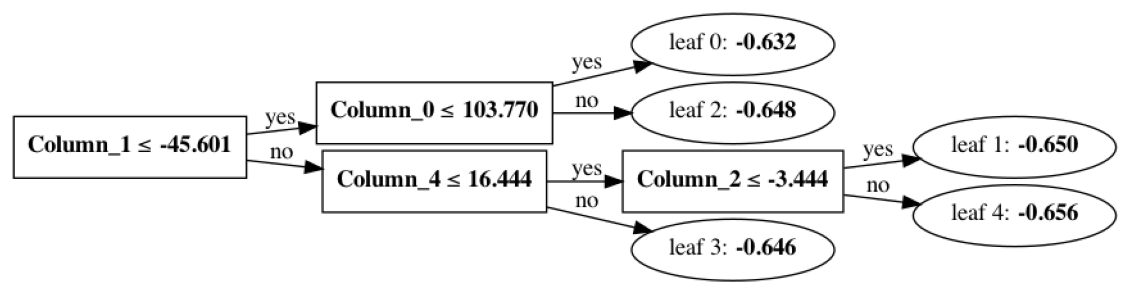

In [115]:
lgb.plot_tree(gbm,figsize = (20,20))

# Multilayer Perceptron

In [98]:
mlp = MLPClassifier(hidden_layer_sizes=16,max_iter=10000).fit(X_train,y_train)

In [99]:
print(mlp.score(X_train,y_train))
print(mlp.score(X_test,y_test))

0.7527472527472527
0.7391304347826086


In [100]:
Y0_mpl = mlp.predict_proba(X_train)[:,1]
Y1_mpl = mlp.predict_proba(X_test)[:,1]
print("ROC AUC train", roc_auc_score(y_train,Y0_mpl))
print("ROC AUC test", roc_auc_score(y_test,Y1_mpl))

ROC AUC train 0.7874979079497908
ROC AUC test 0.6709677419354838


In [101]:
print("MLP Train:")
print(classification_report(y_train,mlp.predict(X_train)))

print("MLP Test:")
print(classification_report(y_test,mlp.predict(X_test)))

MLP Train:
                  precision    recall  f1-score   support

High Performance       0.76      0.92      0.83       239
 Low Performance       0.74      0.43      0.55       125

        accuracy                           0.75       364
       macro avg       0.75      0.68      0.69       364
    weighted avg       0.75      0.75      0.73       364

MLP Test:
                  precision    recall  f1-score   support

High Performance       0.76      0.89      0.82        62
 Low Performance       0.65      0.43      0.52        30

        accuracy                           0.74        92
       macro avg       0.71      0.66      0.67        92
    weighted avg       0.73      0.74      0.72        92



# Function

In [102]:
def run_models(model_obj, model_name, model_param_dict, X_train,y_train):
    mdl = model_obj(**model_param_dict[model_name]).fit(X_train,y_train)
    
    train_score = mdl.score(X_train,y_train)
    test_score = mdl.score(X_test,y_test)
    
    Y0_mdl = logit.predict_proba(X_train)[:,1]
    Y1_mdl = logit.predict_proba(X_test)[:,1]
    roc_auc_0, roc_auc_1 = roc_auc_score(y_train,Y0_mdl), roc_auc_score(y_test,Y1_mdl)
    
    class_report_train = classification_report(y_train,mdl.predict(X_train))
    class_report_test = classification_report(y_test,mdl.predict(X_test))
    
    print(f'{model_name} Performance \n')
    print('Train Score', train_score)
    print('Test Score', test_score)
    print(class_report_train)
    print(class_report_test)
    
    


In [103]:
rf.base_estimator

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [104]:
model_param_dict  = {
    'MLPClassifier': {
        'hidden_layer_sizes': 16,
        'max_iter': 10000
    },
    'LogisticRegression': {
        'max_iter': 1e6
    },
    'LGBMClassifier': {
        "boosting_type":'gbdt', 
         "objective": 'binary',
         "num_boost_round":2000, 
         "metric": 'auc',
         "lambda_l1" : 0.1,
         "lambda_l2" : 0.1,
         "learning_rate":0.01,
         "min_data_in_leaf" : 140,
         "num_leaves":10,
         "reg_alpha":0.1
    },
    'RandomForestClassifier': {
        'bootstrap': True, 
        'max_depth': 4, 
        'max_features': 0.3, 
        'n_estimators': 100
    }
    
}

In [105]:
from lightgbm import LGBMClassifier

In [106]:
run_models(RandomForestClassifier, 'RandomForestClassifier', model_param_dict, X_train,y_train)

RandomForestClassifier Performance 

Train Score 0.8021978021978022
Test Score 0.75
                  precision    recall  f1-score   support

High Performance       0.78      0.96      0.86       239
 Low Performance       0.87      0.50      0.63       125

        accuracy                           0.80       364
       macro avg       0.83      0.73      0.75       364
    weighted avg       0.82      0.80      0.78       364

                  precision    recall  f1-score   support

High Performance       0.75      0.94      0.83        62
 Low Performance       0.73      0.37      0.49        30

        accuracy                           0.75        92
       macro avg       0.74      0.65      0.66        92
    weighted avg       0.75      0.75      0.72        92



# Kmeans

In [107]:
cluster = KMeans(2, random_state=42).fit_predict(X)

In [108]:
cluster

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [109]:
print(classification_report(np.where(Y == 'Low Performance',1,0), cluster))

              precision    recall  f1-score   support

           0       0.61      0.71      0.66       301
           1       0.19      0.13      0.15       155

    accuracy                           0.52       456
   macro avg       0.40      0.42      0.41       456
weighted avg       0.47      0.52      0.49       456



In [111]:
# print(classification_report(np.where(y_train == 'Low Performance',1,0), cluster))

In [112]:
# Train = test.iloc[:,1:]

In [113]:
# Train = pd.get_dummies(Train, drop_first=True)

In [114]:
# test['cluster'] = cluster.fit_predict(Train)

In [162]:
test.head()

,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,Course activity completion updated,A submission has been submitted.,Submission created.,A file has been uploaded.,Submission form viewed.,...,Quiz attempt submitted,Quiz attempt viewed,User graded,Quiz attempt summary viewed,Quiz attempt started,type,level,Grades,cluster,cluster_new
0,312,869,110,805,89,58,23,22,23,0,...,6,201,4,6,8,Quantitative,undergrad,Low Performance,1,2
1,190,608,32,332,7,69,29,26,29,30,...,6,302,6,4,7,Quantitative,undergrad,High Performance,0,0
2,257,416,75,353,2,69,27,23,27,37,...,7,330,5,5,9,Quantitative,undergrad,Low Performance,0,7
3,331,725,113,564,39,57,32,29,32,37,...,7,319,7,6,8,Quantitative,undergrad,High Performance,1,4
4,544,1114,179,1890,152,85,36,28,36,44,...,6,223,4,6,8,Quantitative,undergrad,High Performance,1,5


In [147]:
sse = {}
for k in range(2,10):
    cluster = KMeans(n_clusters=k, random_state=42)
    test['cluster_new'] = cluster.fit_predict(Train)
    sse[k] = cluster.inertia_

In [148]:
sse

{2: 36660815.64775966,
 3: 23048534.740062375,
 4: 16966755.702908855,
 5: 14746809.231315844,
 6: 13187952.949786333,
 7: 12252948.073787529,
 8: 11633250.244179823,
 9: 10716506.716712987}

Text(0, 0.5, 'SSE')

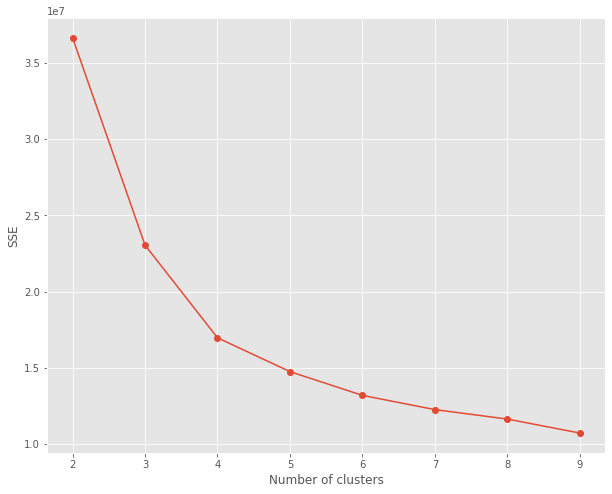

In [149]:
plt.figure(figsize=(10,8))
plt.plot(list(sse.keys()),list(sse.values()),marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

In [153]:
silh_coef = {}
sse = {}
for k in range(2,10):
    cluster = KMeans(n_clusters=k, random_state=42)
    test['cluster_new'] = cluster.fit_predict(Train)
    silh_coef[k] = silhouette_score(Train,cluster.labels_,metric = 'euclidean')

In [155]:
silh_coef

{2: 0.5682947097438025,
 3: 0.4805646178564251,
 4: 0.42633855949875976,
 5: 0.32277298926318054,
 6: 0.3166782612249707,
 7: 0.2682559359854458,
 8: 0.30122563177070677,
 9: 0.25727531801534903}

Text(0, 0.5, 'silhoute score')

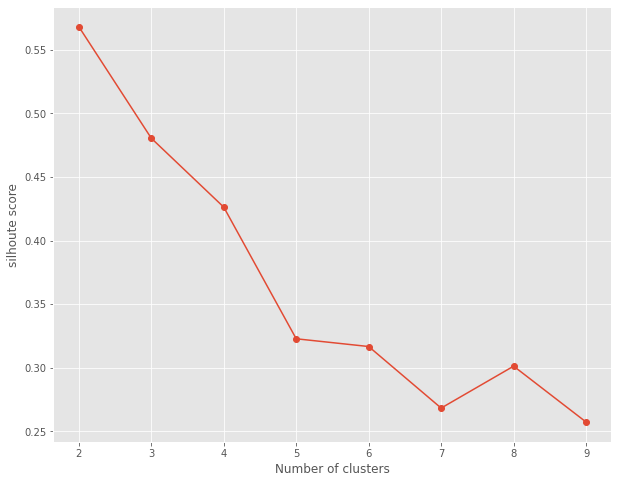

In [154]:
plt.figure(figsize=(10,8))
plt.plot(list(silh_coef.keys()),list(silh_coef.values()),marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('silhoute score')

In [157]:
test

,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,Course activity completion updated,A submission has been submitted.,Submission created.,A file has been uploaded.,Submission form viewed.,...,Quiz attempt submitted,Quiz attempt viewed,User graded,Quiz attempt summary viewed,Quiz attempt started,type,level,Grades,cluster,cluster_new
0,312,869,110,805,89,58,23,22,23,0,...,6,201,4,6,8,Quantitative,undergrad,Low Performance,3,2
1,190,608,32,332,7,69,29,26,29,30,...,6,302,6,4,7,Quantitative,undergrad,High Performance,0,0
2,257,416,75,353,2,69,27,23,27,37,...,7,330,5,5,9,Quantitative,undergrad,Low Performance,0,7
3,331,725,113,564,39,57,32,29,32,37,...,7,319,7,6,8,Quantitative,undergrad,High Performance,3,4
4,544,1114,179,1890,152,85,36,28,36,44,...,6,223,4,6,8,Quantitative,undergrad,High Performance,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,38,103,2,107,12,13,5,7,5,5,...,1,32,0,1,1,Quantitative,grad,High Performance,1,1
470,78,350,5,265,2,43,8,9,8,10,...,1,16,0,1,1,Quantitative,grad,High Performance,1,6
471,20,140,0,148,0,22,6,8,6,7,...,1,22,0,1,1,Quantitative,grad,High Performance,1,1
472,34,203,0,112,11,23,3,5,3,6,...,1,6,0,0,1,Quantitative,grad,High Performance,1,1
